# Rhapso thread router example

This is a demo of how to use the thread router software.

## Prerequisites

You need to install a variety of Python modules:

* [Geometry3D](https://github.com/GouMinghao/Geometry3D)
* [fastcore](https://fastcore.fast.ai)
* [more_itertools](https://more-itertools.readthedocs.io/en/stable/)
* [plotly](https://plotly.com/python/)
* [rich](https://rich.readthedocs.io/)

You'll also need a couple of JupyterLab extensions.

Run the following:

In [ ]:
%%bash
pip install -r requirements.txt
jupyter labextension install jupyterlab-plotly 
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter lab build

## Running the thread router

We'll start with an example file - see `Router test` in the Fusion 360 repository. This is a simple test with four cubes linked by a spiral thread.

First we'll do imports.

In [29]:
#Attempt to reload modules automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from threader import Threader
from geometry import GSegment, GPoint
from tlayer   import TLayer
from gcode    import GcodeFile

import logger, plotting

#This module has setting specific to our current printer setup
import ender3

### Input files

To run the router, we need to have the processed Gcode and the vertices of the thread path. Currently we assume the first thread anchor is at the front-left corner of the print bed (0, 0) and that the ring is oriented at 0° (with the carrier to the right).

In [34]:
gcode_file = 'example/Router test-cura5.gcode'
thread_geom = [GSegment(s, e) for s,e in [
	([18.2689, 14.9338, 3.3333], [18.2689, 36.6005, 3.3333]),
	([18.2689, 36.6005, 3.3333], [36.6023, 36.6005, 3.3333]),
	([36.6023, 36.6005, 3.3333], [36.6023, 18.2672, 3.3333]),
	([36.6023, 18.2672, 3.3333], [21.6023, 18.2672, 3.3333]),
	([21.6023, 18.2672, 3.3333], [21.6023, 21.6005, 6.6667]),
	([21.6023, 21.6005, 6.6667], [21.6023, 36.6005, 6.6667]),
	([21.6023, 36.6005, 6.6667], [33.2689, 36.6005, 6.6667]),
	([33.2689, 36.6005, 6.6667], [33.2689, 21.6005, 6.6667])
]]

In [24]:
gcode = GcodeFile(gcode_file, layer_class=TLayer)
threader = Threader(gcode)

#Necessry to make the accordion fold logging work correctly when this cell is run more than once
logger.restart_logging()

### Running the router

Here we'll run the router, but stop at layer 16, which is the first layer with thread in it. This will allow us to quickly test the router and visualize the result.

In [25]:
test_layer = 16
threader.route_model(thread_geom, end_layer=test_layer+1)

Accordion()

### Visualizing routing steps

The router creates a series of "steps" for each layer. Each step represents either a set of printed geometry or a move of the thread. We can visualize the series of steps for a layer. The first plot is a preview of the full layer, and the remaining plots show each step. Here we show the previous layer's geometry as dim, thin lines.

Preview of 15 steps for layer 16


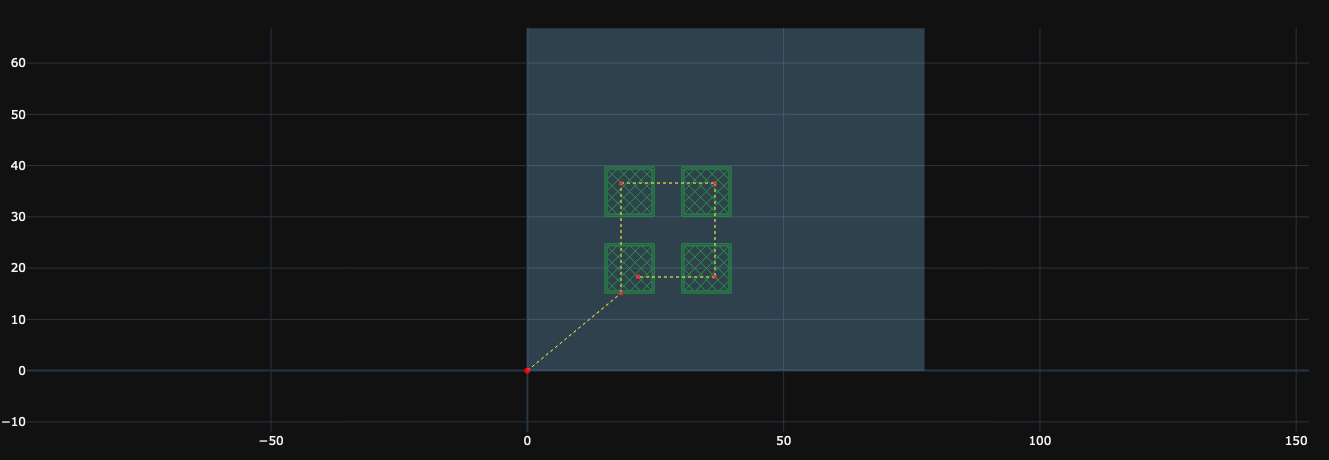

Step 0: Print 37 segments thread doesn't intersect


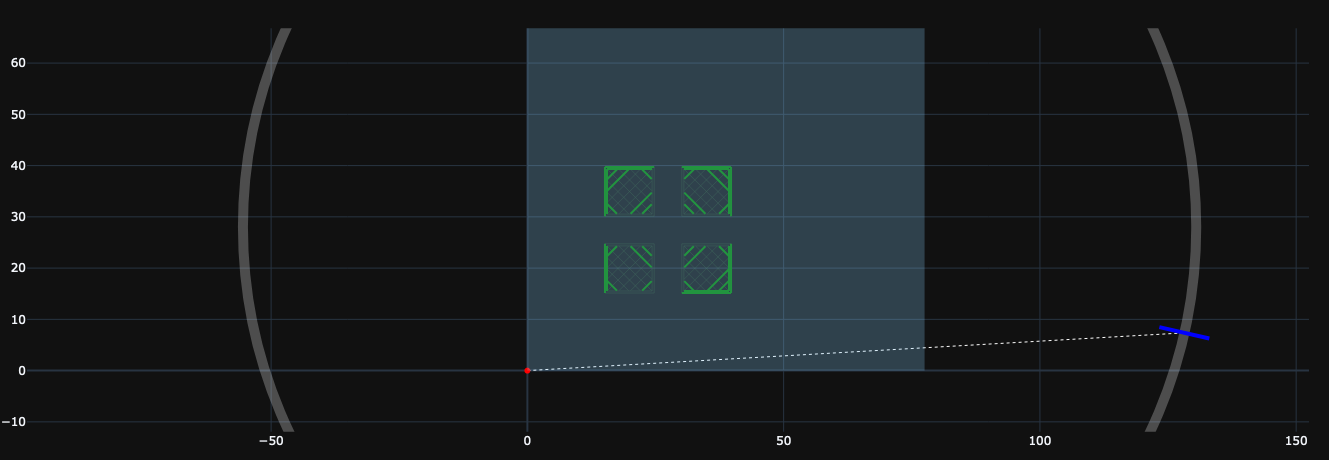

Step 1: Move thread to overlap anchor at { 18.27,  15.13,   3.40}


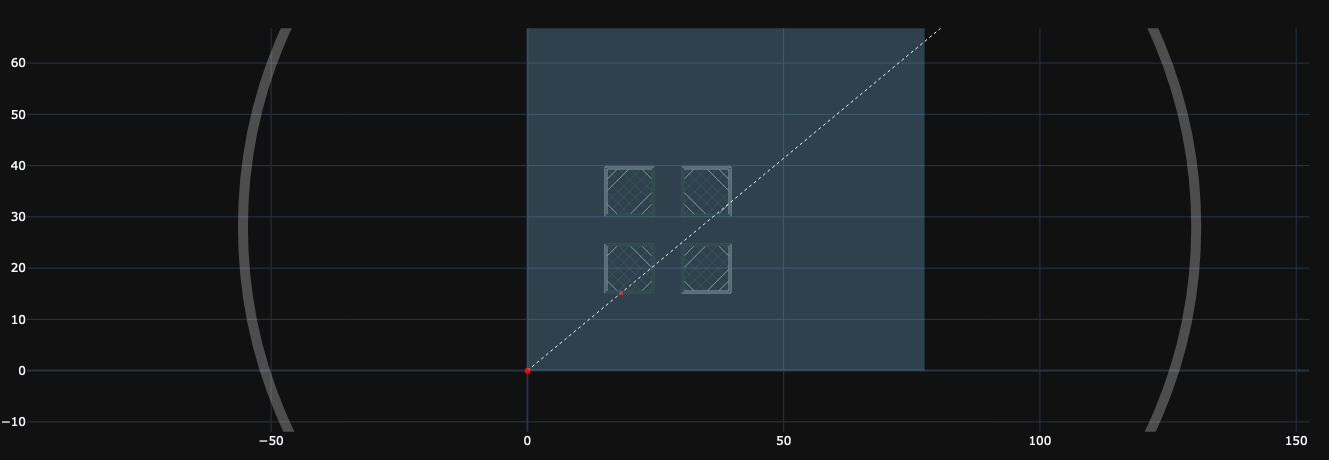

Step 2: Print 1 segment to fix anchor


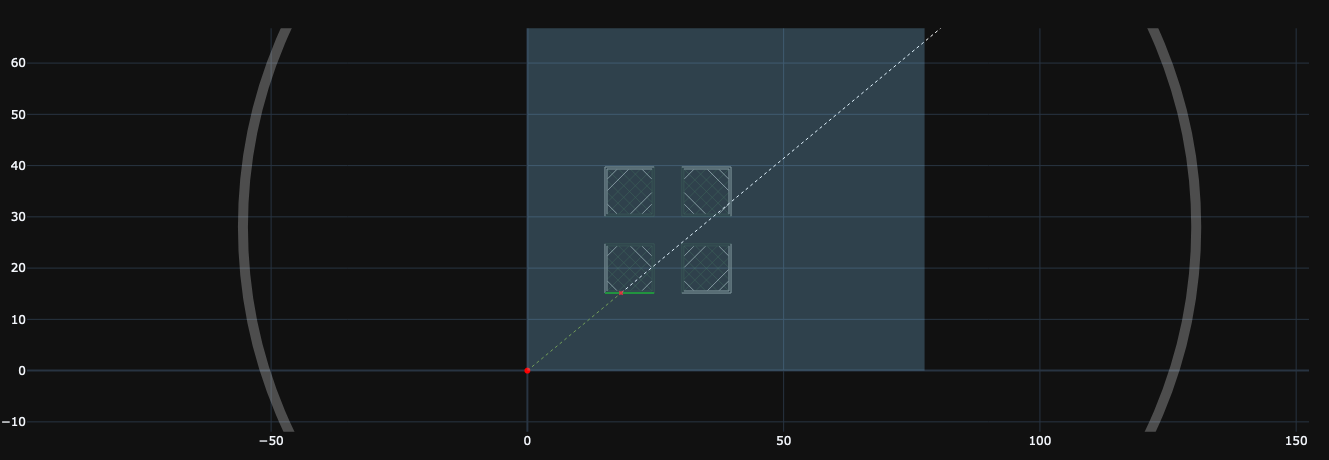

Step 3: Move thread to overlap anchor at { 18.27,  36.60,   3.40}


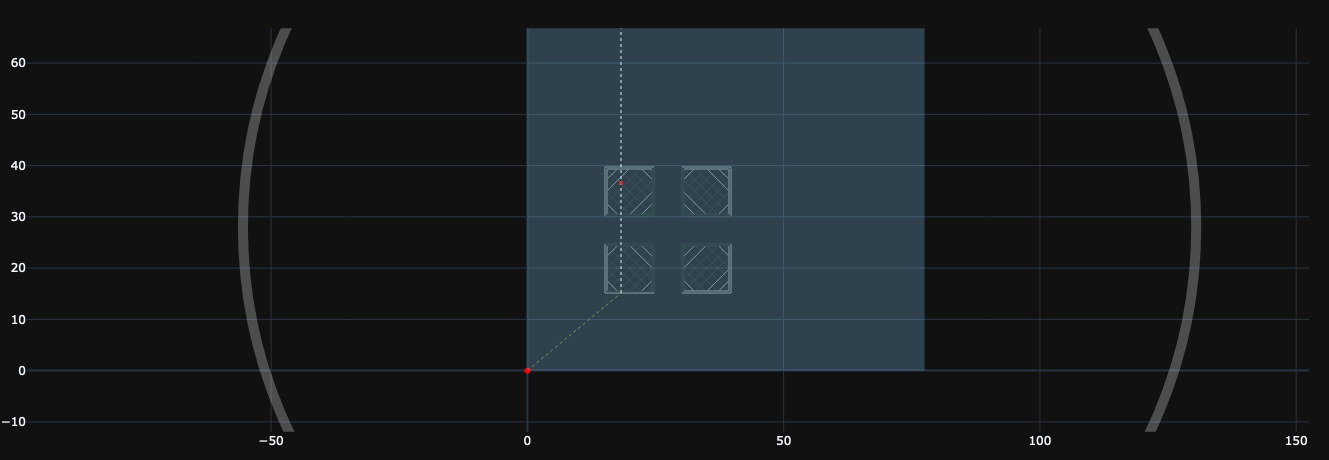

Step 4: Print 1 segment to fix anchor


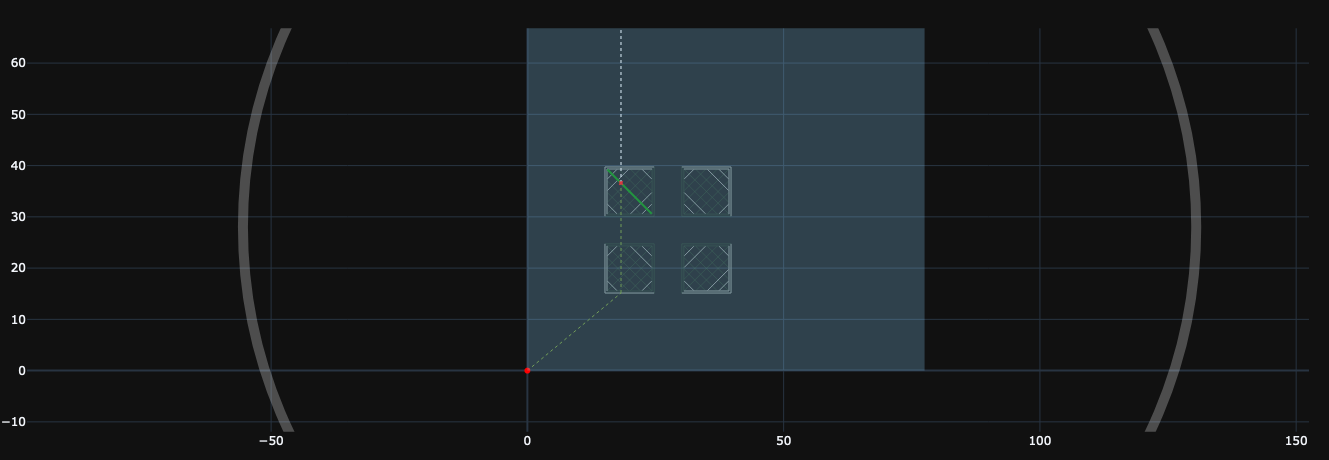

Step 5: Print 13 segments thread doesn't intersect


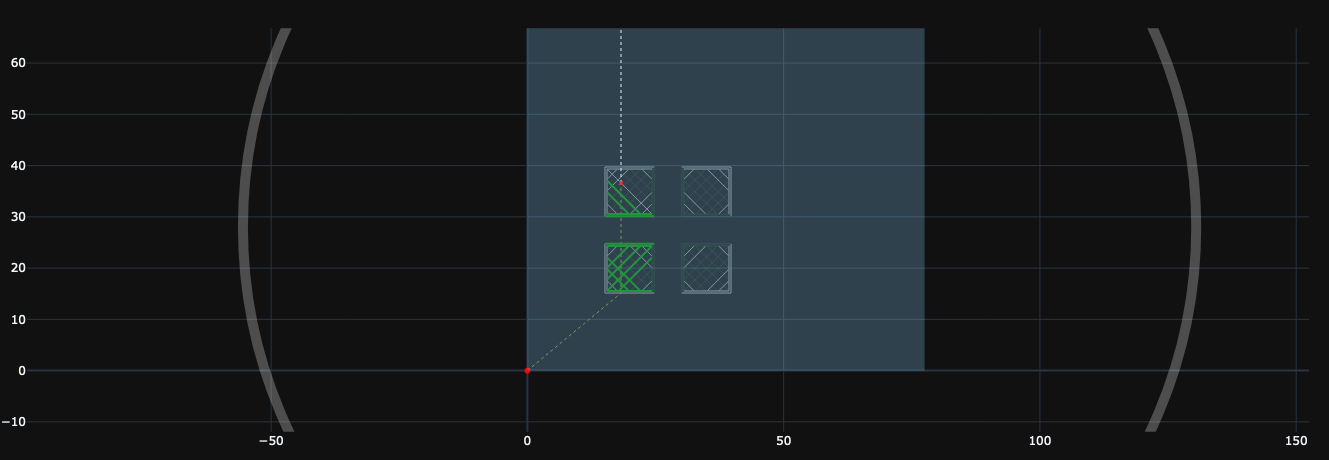

Step 6: Move thread to overlap anchor at { 36.60,  36.60,   3.40}


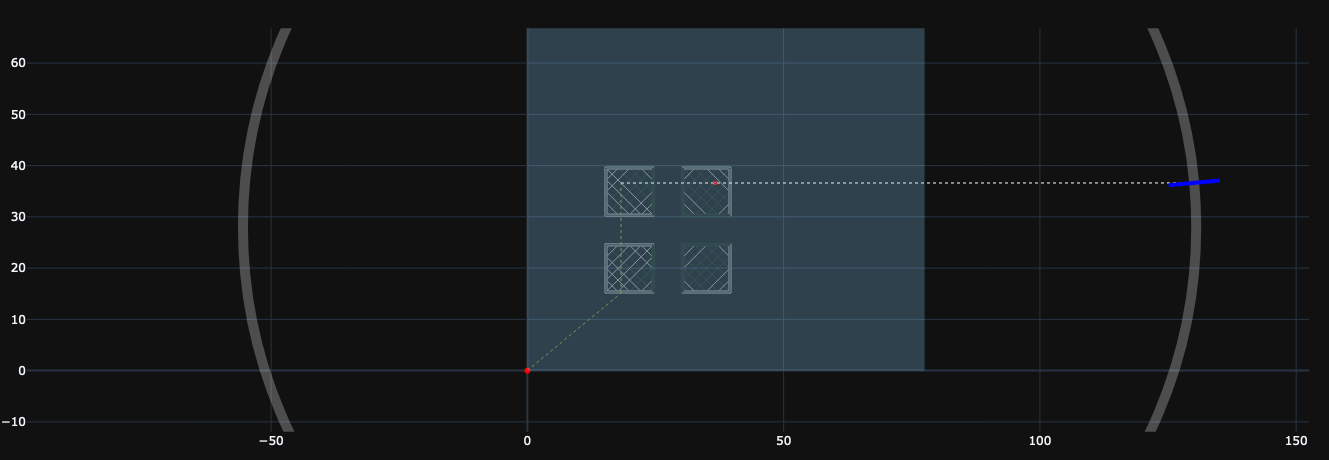

Step 7: Print 1 segment to fix anchor


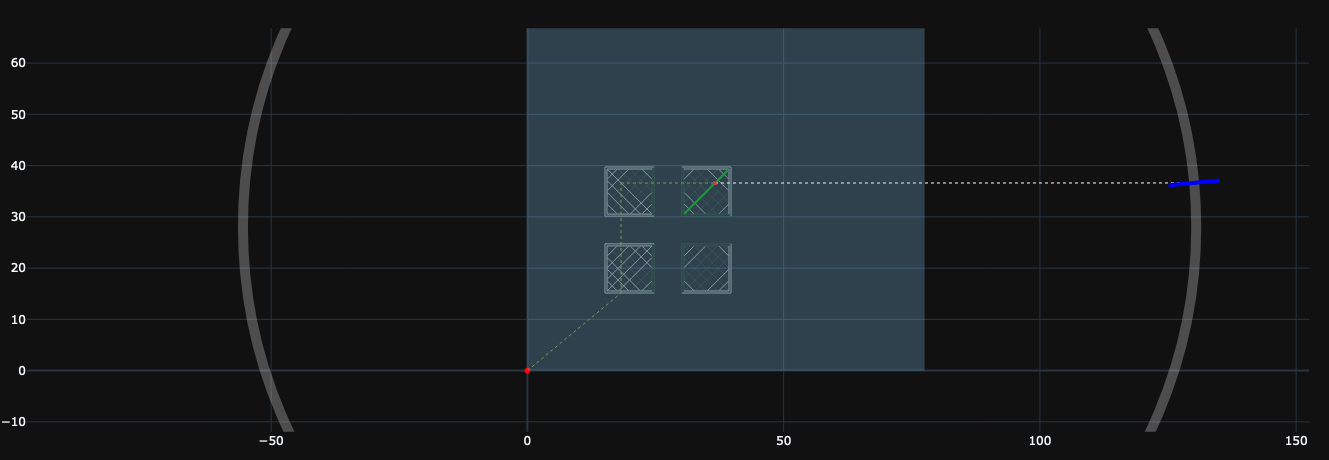

Step 8: Print 11 segments thread doesn't intersect


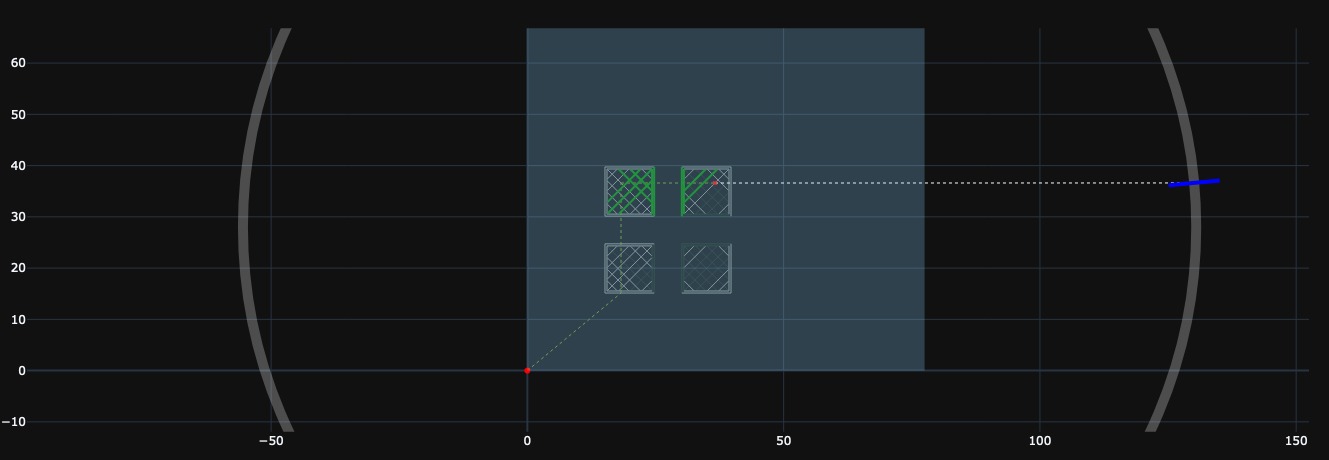

Step 9: Move thread to overlap anchor at { 36.60,  18.27,   3.40}


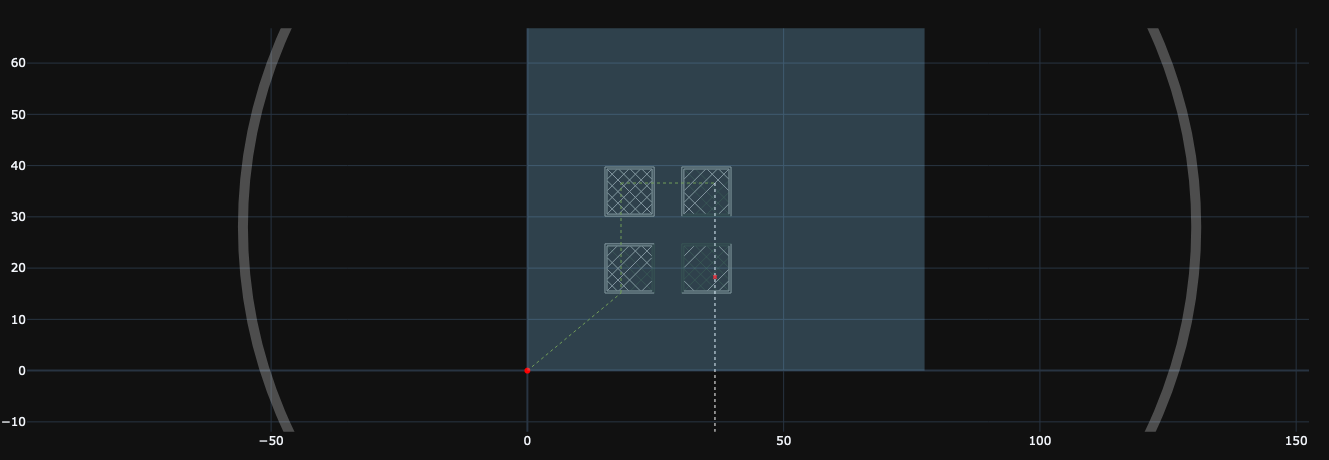

Step 10: Print 1 segment to fix anchor


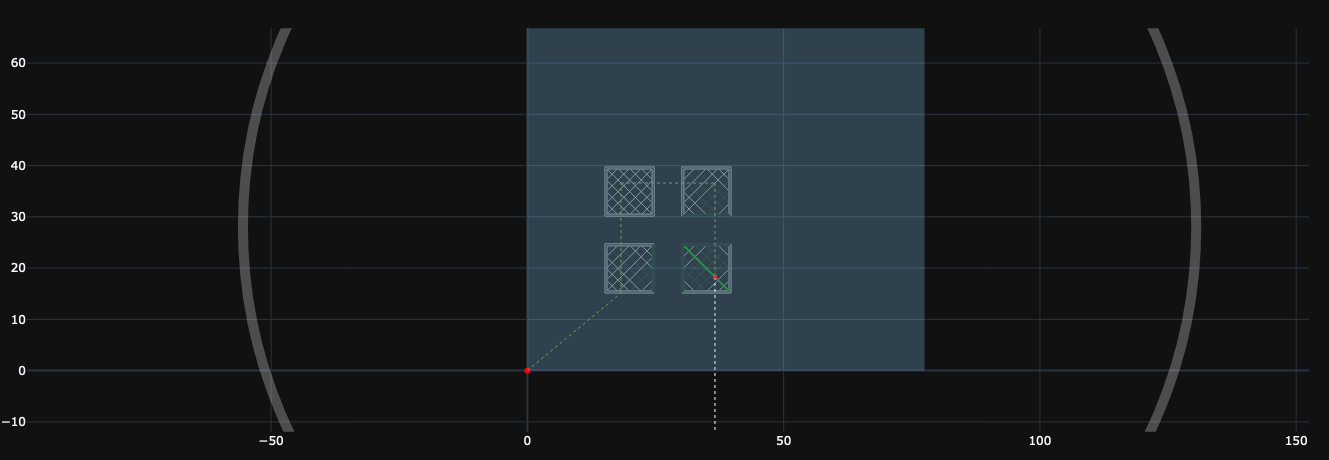

Step 11: Print 11 segments thread doesn't intersect


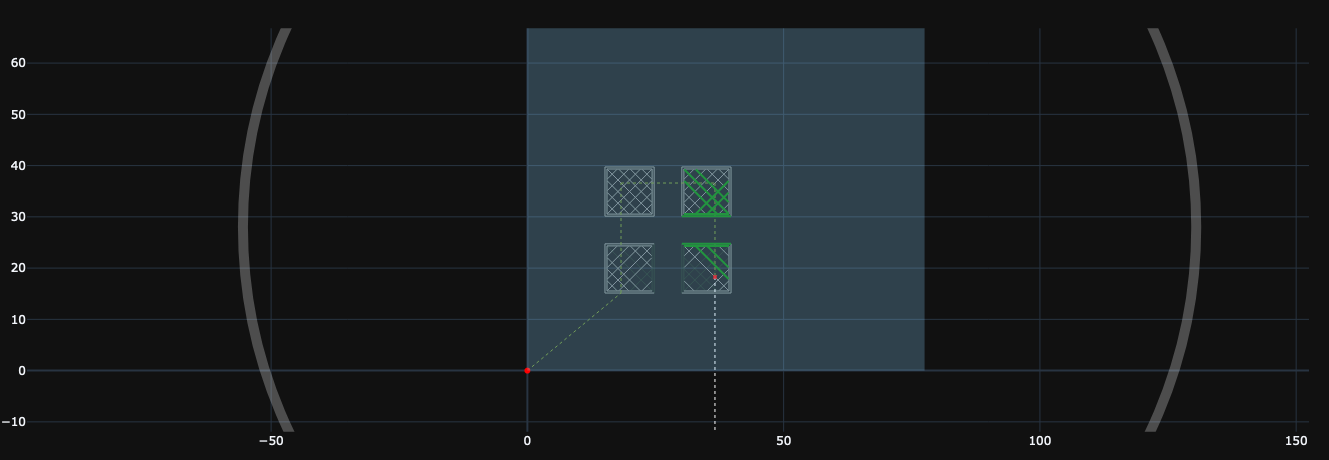

Step 12: Move thread to overlap anchor at { 21.60,  18.27,   3.40}


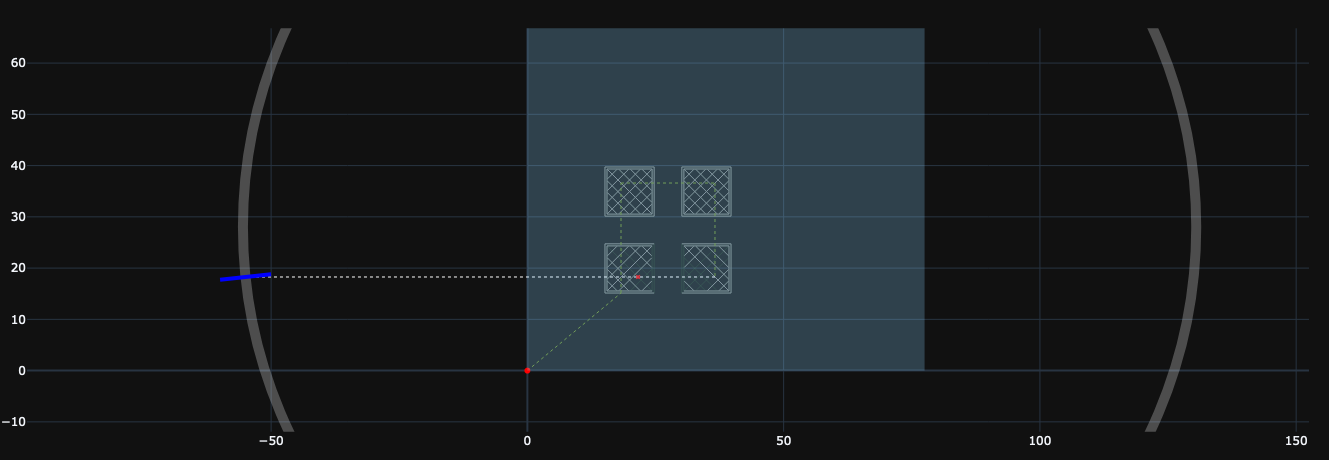

Step 13: Print 1 segment to fix anchor


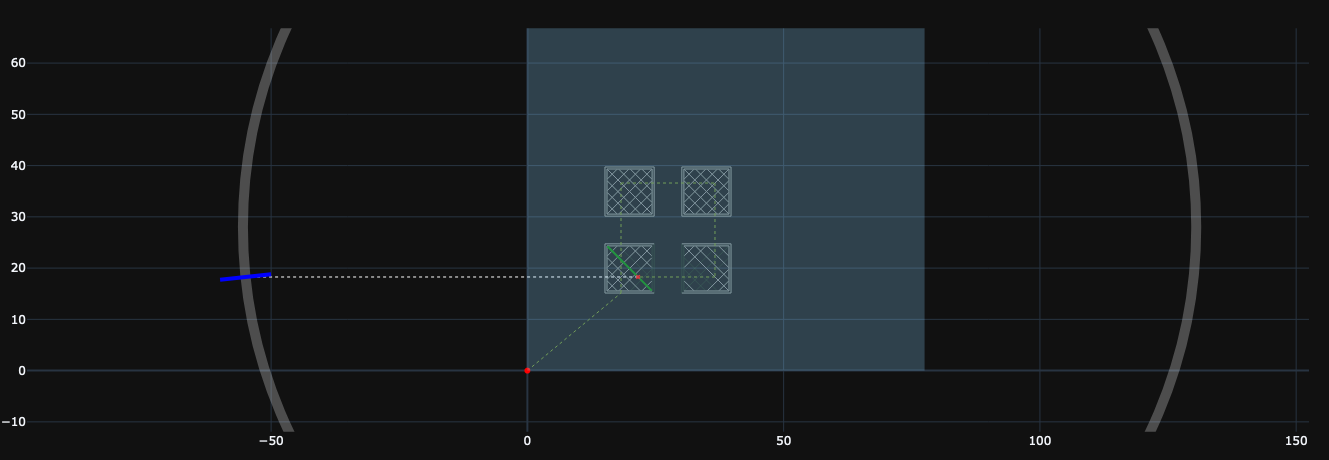

Step 14: Print 11 segments thread doesn't intersect


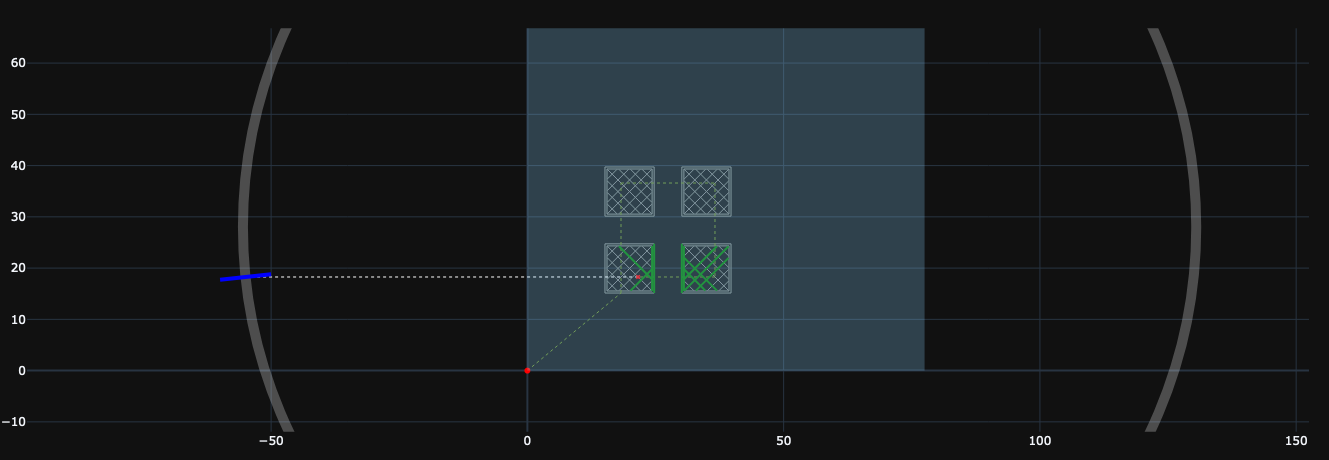

Finished routing this layer


In [27]:
plotting.plot_steps(threader.layer_steps[test_layer], prev_layer=gcode.layers[test_layer-1], prev_layer_only_outline=False)

### Generating and visualizing Gcode

We can generate Gcode for this layer, and animate it to ensure that the generated gcode makes sense:

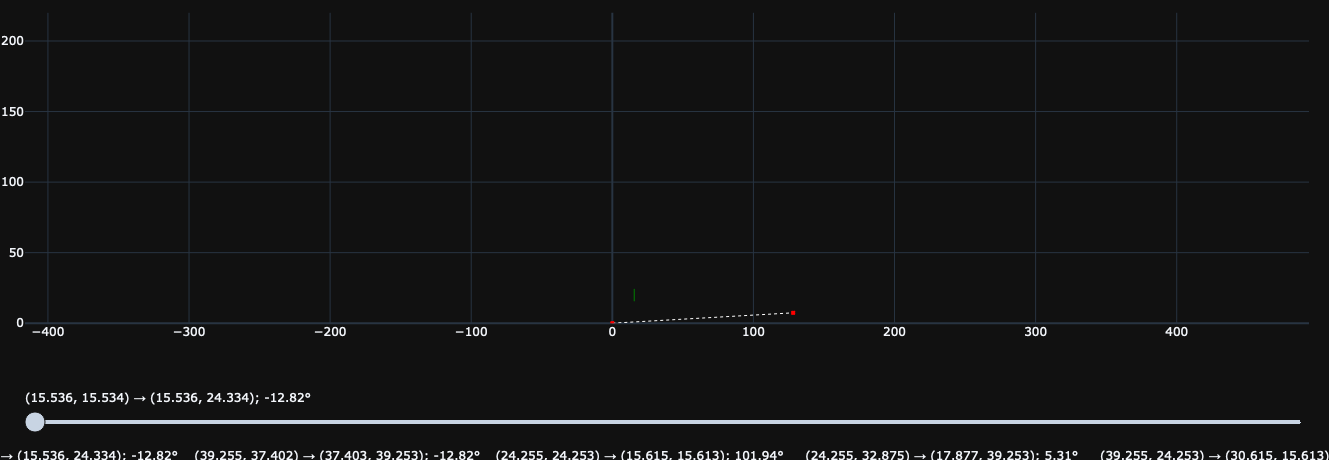

In [33]:
out_gcode = threader.layer_steps[test_layer].gcode()
fig = plotting.animate_gcode(out_gcode, ender3.bed_config, ender3.ring_config, start_angle=threader.layer_steps[test_layer-1].steps[-1].printer.ring.angle)

### Routing the entire model.

Assuming everything looks good, we can generate the complete gcode for the model:

In [43]:
#We have to reinstantiate the gcode object because the router modifies it
gcode = GcodeFile(gcode_file, layer_class=TLayer)
threader2 = Threader(gcode)
logger.restart_logging()
threader2.route_model(thread_geom)

Accordion()

In [44]:
with open('example/Router test-routed.gcode', 'w') as f:
    f.write('\n'.join([l.construct() for l in threader2.gcode()]))